In [1]:
import time
from pathlib import Path
from datetime import datetime, timedelta

import numpy as np
import pandas as pd
import yfinance as yf
import requests
import matplotlib.pyplot as plt
import seaborn as sns
import pulp as pl
import warnings
%matplotlib inline
warnings.filterwarnings("ignore")

In [2]:
# ----------------------------------------------------------------------
# Helper de download
# ----------------------------------------------------------------------
def _download_with_retry(ticker, start, end, attempts=3):
    for _ in range(attempts):
        try:
            df = yf.download(
                ticker, start=start, end=end,
                progress=False, auto_adjust=False, threads=False
            )
            if not df.empty:
                return df
        except Exception:
            pass
        time.sleep(1)
    return pd.DataFrame()

In [ ]:
# ----------------------------------------------------------------------
# Classe principal
# ----------------------------------------------------------------------
class PortfolioSimulator:
    def __init__(self, df_portfolio, valor_aporte_mensal=7_250.0, cdi_aa=0.13):
        self.df_original = df_portfolio.copy()
        if self.df_original["% Ideal - Ref."].max() > 1:
            self.df_original["% Ideal - Ref."] /= 100.0
        self.aporte_mensal = valor_aporte_mensal
        self.cdi_aa = cdi_aa
        # ← lista de classes p/ cálculo de drift
        self.classes = sorted(self.df_original["Classe"].unique())
        
        # Nova estrutura para armazenar aportes detalhados
        self.aportes_detalhados = []

    # ------------- mapeamento de tickers -----------------
    def mapear_tickers(self):
        """Apenas ativos negociados via Yahoo; RF especial fica com próprio nome."""
        mapa = {}
        for _, row in self.df_original.iterrows():
            tk, geo = row["Ticker"], row["Geo."]
            if tk in {"SELIC", "FDI", "FRFH", "LC", "CDB",
                    "IPCA", "CDBI", "PRE", "PGBL"}:
                mapa[tk] = None          # marcador especial
            elif geo == "BR":
                mapa[tk] = f"{tk}.SA"
            elif geo == "US":
                mapa[tk] = tk
        return mapa
    
    @staticmethod
    def _selic_fator_mensal(start, end):
        """SGS 4390 Selic diária → fator acumulado em datas 'M' (últ. dia útil do mês)."""
        url = ("https://api.bcb.gov.br/dados/serie/bcdata.sgs.4390/dados"
            f"?formato=json&dataInicial={start:%d/%m/%Y}&dataFinal={end:%d/%m/%Y}")
        js  = requests.get(url, timeout=10).json()
        df  = pd.DataFrame(js)
        df["data"]  = pd.to_datetime(df["data"], format="%d/%m/%Y")
        df["valor"] = df["valor"].astype(float) / 100        # diário (fração)
        df["fator"] = (1 + df["valor"]).cumprod()
        fator_m = df.set_index("data").resample("M").last()["fator"]
        return fator_m

    @staticmethod
    def _ipca_fator_mensal(start, end):
        """SGS 433 IPCA % mensal → fator acumulado (base 1)."""
        url = ("https://api.bcb.gov.br/dados/serie/bcdata.sgs.433/dados"
            f"?formato=json&dataInicial={start:%d/%m/%Y}&dataFinal={end:%d/%m/%Y}")
        # print(url)
        js  = requests.get(url, timeout=10).json()
        df  = pd.DataFrame(js)
        df["data"]  = pd.to_datetime(df["data"], format="%d/%m/%Y") + pd.offsets.MonthEnd(0)
        df["valor"] = df["valor"].astype(float) / 100
        df["fator"] = (1 + df["valor"]).cumprod()
        return df.set_index("data")["fator"]

    @staticmethod
    def _fator_mensal_fixo(start, end, taxa_anual):
        """Retorna série mensal de fator acumulado (base 1.0) para uma taxa 'anual' constante."""
        idx = pd.date_range(start, end, freq="M")
        taxa_mensal = (1 + taxa_anual) ** (1/12) - 1          # ⇐ conversão
        return pd.Series((1 + taxa_mensal) ** np.arange(1, len(idx)+1), index=idx)

    # ------------- históricos ----------------------------
    def obter_dados_historicos(self, meses):
        end_date   = datetime.now()
        start_date = end_date - timedelta(days=meses*30)

        dados, mapa = {}, self.mapear_tickers()

        usd = _download_with_retry("USDBRL=X", start_date, end_date)["Adj Close"]
        if usd.empty:
            raise RuntimeError("Falha USD/BRL")

        print("Coletando séries…")
        for tk, sym in mapa.items():
            # ─── Renda-fixa e índices ────────────────────────────────
            if tk in {"SELIC", "FDI", "FRFH", "LC", "CDB"}:
                dados[tk] = self._selic_fator_mensal(start_date, end_date)
                # print(f"✓ Selic {tk}")
                continue
            if tk in {"IPCA", "CDBI"}:
                dados[tk] = self._ipca_fator_mensal(start_date, end_date)
                # print(f"✓ IPCA  {tk}")
                continue
            if tk == "PRE":
                dados[tk] = self._fator_mensal_fixo(start_date, end_date, 0.09)   # 9 % a.a.
                # print("✓ PRE  (9 % a.a.)")
                continue
            if tk == "PGBL":
                dados[tk] = self._fator_mensal_fixo(start_date, end_date, 0.07)   # 7 % a.a.
                # print("✓ PGBL (7 % a.a.)")
                continue

            # ─── Ações / ETFs ───────────────────────────────────────
            dfp = _download_with_retry(sym, start_date, end_date)
            if dfp.empty:
                print(f"Sem dados {tk}")
                continue
            serie_m = dfp["Adj Close"].resample("M").last()
            if self.df_original.loc[self.df_original["Ticker"] == tk, "Geo."].iat[0] == "US":
                usd_m = usd.resample("M").last()
                serie_m.values[:] = serie_m.to_numpy()*usd_m.to_numpy()

            dados[tk] = serie_m
            # print(f"✓ {tk}")

        return dados

    # ------------- estratégia 1 -------------------------
    def _aporte_deficit(self, df, valor_cart, aporte, mes, data):
        # df = df[df["Cotação"].notna() & np.isfinite(df["Cotação"])].copy()
        df = df.copy()
        df["Valor Ideal"] = df["% Ideal - Ref."] * (valor_cart + aporte)
        df["deficit"] = (df["Valor Ideal"] - df["Total"]).clip(lower=0)
        
        if df["deficit"].sum() == 0:
            return df, aporte
            
        df["aporte_sugerido"] = df["deficit"] / df["deficit"].sum() * aporte
        df["Qtd_comprar"], df["Custo_real"] = 0.0, 0.0
        
        for i, r in df.iterrows():
            qtd = (r["aporte_sugerido"] / r["Cotação"]) if (r["Classe"] == "RF" and r["Ticker"] != "IMAB11") \
                  else np.floor(r["aporte_sugerido"] / r["Cotação"])
            df.at[i, "Qtd_comprar"] = qtd
            df.at[i, "Custo_real"]  = qtd * r["Cotação"]
            
            # Salvar detalhes do aporte se houve compra
            if qtd > 0:
                self._salvar_aporte_detalhado(r, qtd, qtd * r["Cotação"], "Deficit", mes, data, df)

        return df, aporte - df["Custo_real"].sum()

    # ------------- estratégia 2 -------------------------
    def _aporte_po(self, df, valor_cart, aporte, mes, data):
        # df = df[df["Cotação"].notna() & np.isfinite(df["Cotação"])].copy()
        df = df.copy()
        if df.empty:
            return self._aporte_deficit(df, valor_cart, aporte, mes, data)

        df["Valor Ideal"] = df["% Ideal - Ref."] * (valor_cart + aporte)
        df["deficit"] = (df["Valor Ideal"] - df["Total"]).clip(lower=0)
        prob, qt_rf, qt_rv, gap = pl.LpProblem("PO", pl.LpMinimize), {}, {}, {}

        for idx, r in df.iterrows():
            nome = str(r["Ativo"]).replace(" ", "_").replace(".", "_")
            if (r["Classe"] == "RF" and r["Ticker"] != "IMAB11"):
                qt_rf[idx] = pl.LpVariable(f"RF_{nome}", lowBound=0)
            else:
                qt_rv[idx] = pl.LpVariable(f"RV_{nome}", lowBound=0, cat="Integer")
            gap[idx] = pl.LpVariable(f"GAP_{nome}", lowBound=0)

        prob += pl.lpSum(gap.values())
        prob += (pl.lpSum(df.loc[i,"Cotação"]*qt_rf[i] for i in qt_rf) +
                 pl.lpSum(df.loc[i,"Cotação"]*qt_rv[i] for i in qt_rv)) <= aporte

        for idx in df.index:
            preco = df.at[idx, "Cotação"]
            compra = preco * (qt_rf[idx] if idx in qt_rf else qt_rv[idx])
            prob += gap[idx] >= df.at[idx,"deficit"] - compra

        try:
            # pl.LpSolverDefault.msg = 1
            prob.solve(pl.PULP_CBC_CMD(msg=1))
        except pl.PulpError:
            # pl.LpSolverDefault.msg = 1
            # prob.writeLP("model.lp")
            prob.solve()

        if prob.status != pl.LpStatusOptimal:
            print(f'Solução com LP não convergiu')
            return self._aporte_deficit(df, valor_cart, aporte, mes, data)

        df["Qtd_comprar"], df["Custo_real"] = 0.0, 0.0
        
        for idx, var in qt_rf.items():
            qtd = var.varValue or 0
            df.at[idx,"Qtd_comprar"] = qtd
            df.at[idx,"Custo_real"]  = qtd * df.at[idx,"Cotação"]
            
            # Salvar detalhes do aporte se houve compra
            if qtd > 0:
                self._salvar_aporte_detalhado(df.loc[idx], qtd, qtd * df.at[idx,"Cotação"], "PO", mes, data, df)
                
        for idx, var in qt_rv.items():
            qtd = int(var.varValue or 0)
            df.at[idx,"Qtd_comprar"] = qtd
            df.at[idx,"Custo_real"]  = qtd * df.at[idx,"Cotação"]
            
            # Salvar detalhes do aporte se houve compra
            if qtd > 0:
                self._salvar_aporte_detalhado(df.loc[idx], qtd, qtd * df.at[idx,"Cotação"], "PO", mes, data, df)

        return df, aporte - df["Custo_real"].sum()

    # ------------- método para salvar aportes detalhados ---------------
    def _salvar_aporte_detalhado(self, row, qtd_aportada, valor_aportado, estrategia, mes, data, df_cart):
        """Salva os detalhes do aporte para um ativo específico"""
        # Calcular % Atual e Variação
        valor_total_carteira = df_cart["Total"].sum()
        pct_atual = (row["Total"] / valor_total_carteira) * 100 if valor_total_carteira > 0 else 0
        pct_ideal = row["% Ideal - Ref."] * 100
        variacao = pct_atual - pct_ideal
        
        aporte_info = {
            'Mes': mes,
            'Data': data,
            'Estrategia': estrategia,
            'Geo': row.get("Geo.", ""),
            'Classe': row.get("Classe", ""),
            'Subclasses': row.get("Subclasses", ""),
            'Setor': row.get("Setor", ""),
            'Ativo': row.get("Ativo", ""),
            'Ticker': row.get("Ticker", ""),
            'Qnt_Total': row.get("Qnt.", 0),
            'Cotacao': row.get("Cotação", 0),
            'Total': row.get("Total", 0),
            'Pct_Atual': pct_atual,
            'Pct_Ideal': pct_ideal,
            'Variacao': variacao,
            'Qnt_Aportado': qtd_aportada,
            'Valor_Aportado': valor_aportado
        }
        
        self.aportes_detalhados.append(aporte_info)

    # ------------- método para obter dataframe de aportes --------------
    def obter_df_aportes(self):
        """Retorna DataFrame com todos os aportes detalhados"""
        if not self.aportes_detalhados:
            return pd.DataFrame()
        
        df_aportes = pd.DataFrame(self.aportes_detalhados)
        
        # Renomear colunas para o formato solicitado
        # df_aportes = df_aportes.rename(columns={
        #     'Qnt_Total': 'Qnt',
        #     'Cotacao': 'Cotação',
        #     'Pct_Atual': '% Atual',
        #     'Pct_Ideal': '% Ideal',
        #     'Qnt_Aportado': 'Qnt aportado',
        #     'Valor_Aportado': 'Valor aportado'
        # })
        
        # Separar por estratégia
        # df_deficit = df_aportes[df_aportes['Estrategia'] == 'Deficit'].copy()
        # df_po = df_aportes[df_aportes['Estrategia'] == 'PO'].copy()
        
        # if not df_deficit.empty:
        #     df_deficit = df_deficit.rename(columns={
        #         'Qnt_Aportado': 'Qnt_aportado_deficit',
        #         'Valor_Aportado': 'Valor_aportado_deficit'
        #     })
            
        # if not df_po.empty:
        #     df_po = df_po.rename(columns={
        #         'Qnt_Aportad': 'Qnt aportado PO',
        #         'Valor_Aportad': 'Valor aportado PO'
        #     })
        
        # return df_deficit, df_po
        return df_aportes

    # ------------- loop principal -----------------------
    def simular(self, meses=24):
        # Limpar aportes anteriores
        self.aportes_detalhados = []
        
        dados = self.obter_dados_historicos(meses)
        cart_d, cart_p = self.df_original.copy(), self.df_original.copy()

        dates = pd.date_range(end=datetime.now(), periods=meses, freq="MS")
        valor_inicial = cart_d["Total"].sum()
        # valor_inicial_classe = (
        #     cart_d.groupby("Classe")["Total"].sum().to_dict()
        # )

        aporte_acum, out = 0.0, []

        # --------------------------------------------------------------
        # acumuladores de aportes por classe e por estratégia
        # --------------------------------------------------------------
        aportado_def = {cls: 0.0 for cls in self.classes}
        aportado_po  = {cls: 0.0 for cls in self.classes}

        for imes, dt in enumerate(dates, 1):
            # print(imes)
            # preços atualizados
            for cart in (cart_d, cart_p):
                for idx, r in cart.iterrows():
                    tk = r["Ticker"]
                    if tk not in dados: continue
                    s = dados[tk][dados[tk].index <= dt]
                    
                    if s.empty:
                        continue
                    v_raw = s.iloc[-1]                     # pode ser escalar ou Series
                    # extrai o primeiro elemento se for iterável
                    v = float(np.asarray(v_raw).flatten()[0])
                    cart.at[idx, "Cotação"] = v
                cart["Total"] = cart["Qnt."] * cart["Cotação"]

            # aportes (passando mes e data para tracking)
            aporte_acum += self.aporte_mensal
            res_d, sobra_d = self._aporte_deficit(cart_d, cart_d["Total"].sum(), self.aporte_mensal, imes, dt)
            res_p, sobra_p = self._aporte_po(cart_p, cart_p["Total"].sum(), self.aporte_mensal, imes, dt)

            cart_d["Qnt."] += res_d["Qtd_comprar"]; cart_p["Qnt."] += res_p["Qtd_comprar"]
            cart_d["Total"] = cart_d["Qnt."] * cart_d["Cotação"]
            cart_p["Total"] = cart_p["Qnt."] * cart_p["Cotação"]

            # sobras → SELIC
            for cart, sobra, estrategia in ((cart_d,sobra_d,"Deficit"),(cart_p,sobra_p,"PO")):
                if sobra>0 and (cart["Ticker"]=="SELIC").any():
                    idx = cart[cart["Ticker"]=="SELIC"].index[0]
                    cart.at[idx,"Qnt."]  += sobra
                    cart.at[idx,"Total"] += sobra
                    
                    # Registrar sobra como aporte na SELIC
                    if sobra > 0:
                        self._salvar_aporte_detalhado(cart.loc[idx], sobra, sobra, estrategia, imes, dt, cart)

            investido = valor_inicial + aporte_acum
            vt_d, vt_p = cart_d["Total"].sum(), cart_p["Total"].sum()
            rent_def_corr = (vt_d/investido -1)*100
            rent_po_corr = (vt_p/investido -1)*100
            # total atual por classe
            # totais_def = cart_d.groupby("Classe")["Total"].sum()
            # totais_po  = cart_p.groupby("Classe")["Total"].sum()
            # rentabilidade % por classe (RF e RV)
            # rent_def_rf = (
            #     (totais_def.get("RF", 0) /
            #     valor_inicial_classe.get("RF", 1) - 1) * 100
            # )
            # rent_def_rv = (
            #     (totais_def.get("RV", 0) /
            #     valor_inicial_classe.get("RV", 1) - 1) * 100
            # )
            # rent_po_rf  = (
            #     (totais_po.get("RF", 0) /
            #     valor_inicial_classe.get("RF", 1) - 1) * 100
            # )
            # rent_po_rv  = (
            #     (totais_po.get("RV", 0) /
            #     valor_inicial_classe.get("RV", 1) - 1) * 100
            # )

            # ---- drift por classe (usar carteira déficit para referência) ---
            drift = {}
            for cls in self.classes:
                # pesos alvo são os mesmos p/ as duas carteiras
                peso_alvo = cart_d[cart_d["Classe"] == cls]["% Ideal - Ref."].sum()

                peso_def  = cart_d[cart_d["Classe"] == cls]["Total"].sum() / vt_d
                peso_po   = cart_p[cart_p["Classe"] == cls]["Total"].sum() / vt_p

                drift[f"drift_{cls}_def"] = (peso_def - peso_alvo) * 100   # p.p.
                drift[f"drift_{cls}_po"]  = (peso_po  - peso_alvo) * 100

            out.append({
                "mes": imes, "data": dt,
                "investido": investido,
                "valor_def": vt_d, "valor_po": vt_p,
                "deficit_def": (cart_d["% Ideal - Ref."]*vt_d - cart_d["Total"]).clip(lower=0).sum(),
                "deficit_po":  (cart_p["% Ideal - Ref."]*vt_p - cart_p["Total"]).clip(lower=0).sum(),
                "rent_def_corr": rent_def_corr,
                "rent_po_corr":  rent_po_corr,
                # "rent_def_rf"  : rent_def_rf,
                # "rent_po_rf"   : rent_po_rf,
                # "rent_def_rv"  : rent_def_rv,
                # "rent_po_rv"   : rent_po_rv,
                **drift
            })

        return pd.DataFrame(out)

    # ------------- plotagem -----------------------------
    def plotar(self, df):
        cor_def, cor_po = "#060dd6", "#de1f35"
        pal_classes = ['forestgreen', 'black']  #descomentar quando trabalhar com classes

        fig, axs = plt.subplots(2, 2, figsize=(16, 11))
        (a1, a2), (a3, a4) = axs

        # 1) Déficit (log)
        eps = 1e-2
        sns.lineplot(x=df["mes"], y=df["deficit_def"].clip(lower=eps), ax=a1,
                    color=cor_def, label="Déficit", lw=2.5)
        sns.lineplot(x=df["mes"], y=df["deficit_po"].clip(lower=eps), ax=a1,
                    color=cor_po,  label="PO", lw=2.5)
        a1.set(title="Déficit Total (log)",
               xlabel="Mês", 
               ylabel="R$")
        a1.grid(ls="--", alpha=.5)

        # 2) Rentabilidade corrigida
        sns.lineplot(x="mes", y="rent_def_corr", data=df, ax=a2,
                    color=cor_def, label="Déficit",lw=2.5 )
        sns.lineplot(x="mes", y="rent_po_corr",  data=df, ax=a2,
                    color=cor_po,  label="PO", lw=2.5)
        a2.set(title="Rentabilidade (%) sobre capital investido",
            xlabel="Mês", ylabel="%")
        a2.grid(ls="--", alpha=.25)

        # 3) Drift por classe – duas curvas por classe
        for cls, cor in zip(self.classes, pal_classes):
            sns.lineplot(x="mes", y=f"drift_{cls}_def", data=df, ax=a3,
                        color=cor, lw=2.5,
                        label=f"{cls} – Déficit")
            sns.lineplot(x="mes", y=f"drift_{cls}_po",  data=df, ax=a3,
                        color=cor, lw=2.5, ls="--",
                        label=f"{cls} – PO")

        a3.axhline(0, ls=":", c="k", lw=1)
        a3.set(title="Drift por classe (p.p.)",
            xlabel="Mês", ylabel="Peso real – alvo")
        a3.grid(ls="--", alpha=.25)
        # legenda compacta: remove duplicatas mantendo ordem
        handles, labels = a3.get_legend_handles_labels()
        uniq = dict(zip(labels, handles))
        a3.legend(uniq.values(), uniq.keys(), ncol=2, frameon=False)

        # 4) Valor de mercado
        sns.lineplot(x="mes", y="valor_def", data=df, ax=a4,
                    color=cor_def, label="Déficit",lw=2.0 )
        sns.lineplot(x="mes", y="valor_po",  data=df, ax=a4,
                    color=cor_po,  label="PO",lw=2.0)
        a4.set(title="Valor da Carteira (R$)", xlabel="Mês", ylabel="R$")
        a4.grid(ls="--", alpha=.25)

        # eixo x inteiro
        for ax in axs.flat:
            ax.set_xticks(df["mes"])

        plt.tight_layout()
        plt.show()
        return fig

In [87]:
# ----------------------------------------------------------------------
# Execução
# ----------------------------------------------------------------------

# df_port = pd.read_csv('./data/portfolio_20250526_tratado.csv', sep=';', index_col=0)
df_port = pd.read_csv('./data/fake_data_port.csv', sep=';', index_col=0)
sim     = PortfolioSimulator(df_port, valor_aporte_mensal=2500)

print("🚀 Simulando…")
df_out  = sim.simular(meses=24)

# print("📊 Plotando…")
# sim.plotar(df_out)

# 🆕 NOVO: Obter DataFrames de aportes detalhados
print("📋 Gerando DataFrames de aportes detalhados...")
# df_aportes_deficit, df_aportes_po = sim.obter_df_aportes()
df_aportes = sim.obter_df_aportes()

# print(f"✅ Aportes Déficit: {len(df_aportes_deficit)} registros")
# print(f"✅ Aportes PO: {len(df_aportes_po)} registros")
print("✅ Fim!")

🚀 Simulando…
Coletando séries…
https://api.bcb.gov.br/dados/serie/bcdata.sgs.433/dados?formato=json&dataInicial=27/06/2023&dataFinal=16/06/2025
https://api.bcb.gov.br/dados/serie/bcdata.sgs.433/dados?formato=json&dataInicial=27/06/2023&dataFinal=16/06/2025
📋 Gerando DataFrames de aportes detalhados...
✅ Fim!


### Análises

#### Drift por Classes (Renda Fixa e Renda Variável) ao longo dos meses

In [84]:
sns.set_theme(style="white", context="paper") 

In [95]:
df_out.head()

,mes,data,investido,valor_def,valor_po,deficit_def,deficit_po,rent_def_corr,rent_po_corr,drift_RF_def,drift_RF_po,drift_RV_def,drift_RV_po
0,1,2023-07-01 22:38:49.824706,299114.42,210998.577823,210998.577823,86893.979386,86893.979386,-29.458908,-29.458908,9.364585,8.612915,-9.364585,-8.612915
1,2,2023-08-01 22:38:49.824706,301614.42,216004.524376,215863.009887,86971.036919,87019.691057,-28.383887,-28.430806,9.353963,7.876049,-9.353963,-7.876049
2,3,2023-09-01 22:38:49.824706,304114.42,216850.152053,216738.787758,86654.918355,85743.097582,-28.694551,-28.731170,10.255764,8.008585,-10.255764,-8.008585
3,4,2023-10-01 22:38:49.824706,306614.42,220292.890579,220317.450543,86965.987771,84926.027983,-28.153121,-28.145111,10.522454,8.645112,-10.522454,-8.645112
4,5,2023-11-01 22:38:49.824706,309114.42,220436.347651,220217.535623,85430.932746,82060.026388,-28.687782,-28.758569,11.580384,10.098183,-11.580384,-10.098183


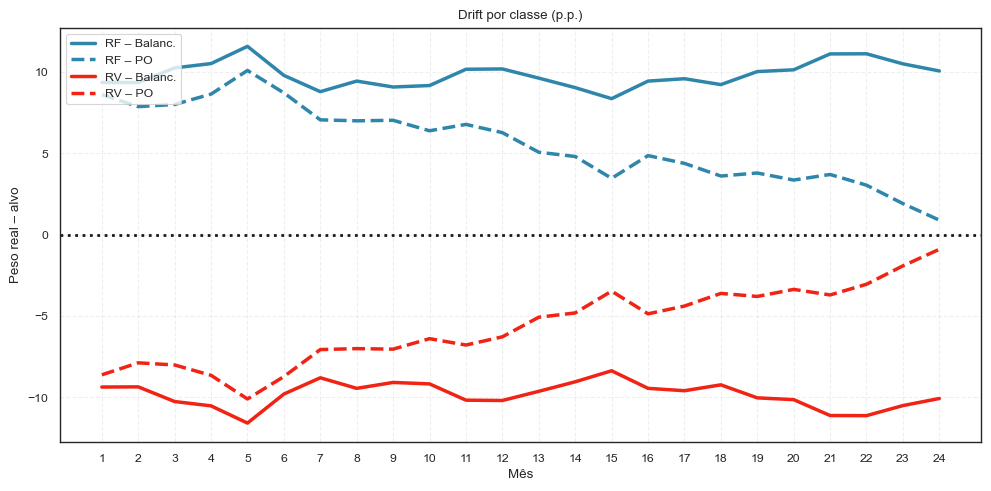

In [88]:
plt.figure(figsize=(10,5))

classes = ['RF', 'RV']
cor = ['#2E86AB', "#F02314"]

for cls, cor in zip(classes, cor):
    sns.lineplot(x="mes", y=f"drift_{cls}_def", data=df_out,
                color=cor, lw=2.5,
                label=f"{cls} – Balanc.")
    sns.lineplot(x="mes", y=f"drift_{cls}_po",  data=df_out,
                color=cor, lw=2.5, ls="--",
                label=f"{cls} – PO")

plt.axhline(0, ls=":", c="k", lw=2)
plt.title("Drift por classe (p.p.)")
plt.xlabel("Mês")
plt.xticks(df_out["mes"].unique())
plt.ylabel("Peso real – alvo")
plt.grid(ls="--", alpha=.3)
plt.legend(loc='upper left')


# for ax in axs.flat:
#     ax.set_xticks(df_out["mes"])

plt.tight_layout()
plt.show()

<Figure size 1200x500 with 0 Axes>

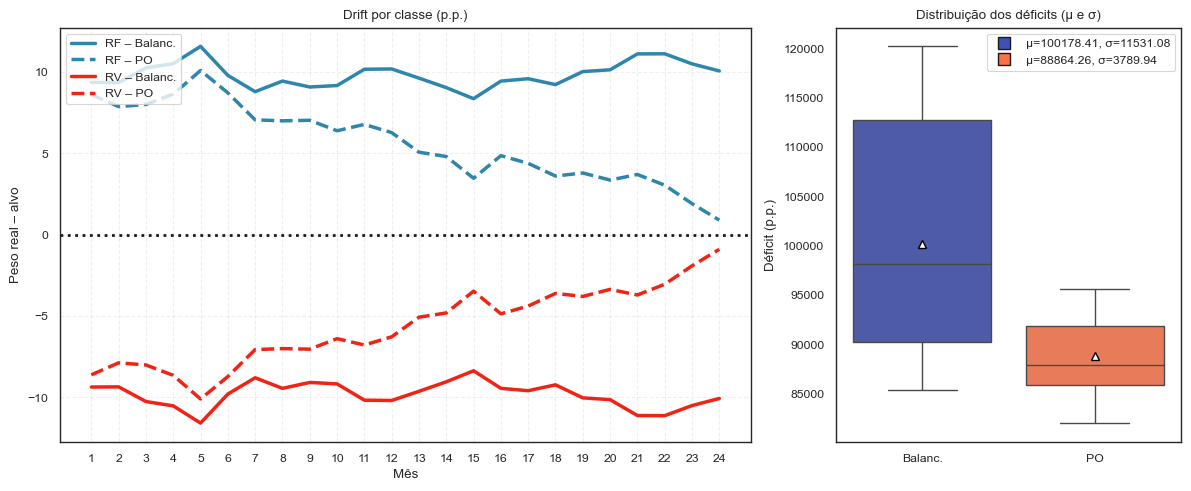

In [116]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

plt.figure(figsize=(12, 5))  # um pouco mais largo para acomodar o boxplot

# ------------------------------------------------------------------
# grade 2 : 1  →  width_ratios = [2,1]
# ------------------------------------------------------------------
fig, (ax_line, ax_box) = plt.subplots(
    ncols=2, figsize=(12, 5), gridspec_kw={"width_ratios": [2, 1]}
)

# ------------------------------------------------------------------
# 1) GRÁFICO DE LINHAS (à esquerda – 2 unidades de largura)
# ------------------------------------------------------------------
classes = ["RF", "RV"]
cores   = ["#2E86AB", "#F02314"]

for cls, color in zip(classes, cores):
    sns.lineplot(
        x="mes", y=f"drift_{cls}_def", data=df_out,
        color=color, lw=2.5, ax=ax_line, label=f"{cls} – Balanc."
    )
    sns.lineplot(
        x="mes", y=f"drift_{cls}_po",  data=df_out,
        color=color, lw=2.5, ls="--",  ax=ax_line, label=f"{cls} – PO"
    )

ax_line.axhline(0, ls=":", c="k", lw=2)
ax_line.set_title("Drift por classe (p.p.)")
ax_line.set_xlabel("Mês")
ax_line.set_xticks(df_out["mes"].unique())
ax_line.set_ylabel("Peso real – alvo")
ax_line.grid(ls="--", alpha=.3)
ax_line.legend(loc="upper left")

# ------------------------------------------------------------------
# 2) BOX-PLOT (à direita – 1 unidade de largura)
# ------------------------------------------------------------------
# transforma em formato longo só para o boxplot
box_df = pd.melt(
    df_out[["deficit_def", "deficit_po"]],
    var_name="Estratégia", value_name="Déficit"
)
box_df['Estratégia'] = box_df['Estratégia'].map({'deficit_def': 'Balanc.', 'deficit_po': 'PO'})

palette = {"Balanc.": "#3F51B5", "PO": "#FF7043"}

sns.boxplot(
    y="Déficit", x="Estratégia", data=box_df,
    ax=ax_box, palette=palette, showmeans=True,
    meanprops={"markerfacecolor":"white",
               "markeredgecolor":"black", "markersize":6}
)

ax_box.set_title("Distribuição dos déficits (μ e σ)")
ax_box.set_xlabel("")  # remove rótulo x
ax_box.set_ylabel("Déficit (p.p.)")

stats = box_df.groupby("Estratégia")["Déficit"].agg(["mean", "std"])

handles, labels = [], []
for estrat, color in palette.items():
    mu, sd = stats.loc[estrat, "mean"], stats.loc[estrat, "std"]
    handle = plt.Line2D([0], [0], marker='s', linestyle='',
                        markerfacecolor=color, markeredgecolor='k',
                        markersize=8)
    handles.append(handle)
    labels.append(f"μ={mu:.2f}, σ={sd:.2f}")

ax_box.legend(handles, labels, loc="upper right",
              frameon=True)

del box_df

plt.tight_layout()
plt.show()

- Podemos observar que a estratégia por Pesquisa Operacional converge melhor para o ponto ótimo (0 p.p.) do que a estratégia por Balanceamento de Déficits.

#### Proporção dos aportes em Renda Fixa, Renda Variável e Qtd. Ativos

In [117]:
df_agg_dft = df_aportes.groupby(["Mes", "Estrategia", "Classe", "Subclasses"], as_index=False, dropna=False).agg(
    vlr_aport=("Valor_Aportado", "sum")
)

df_agg_qt_atv = df_aportes.groupby(['Mes', 'Estrategia'], as_index=False, dropna=False).agg(
    ativos_dist_aport=("Ativo", "nunique")
)


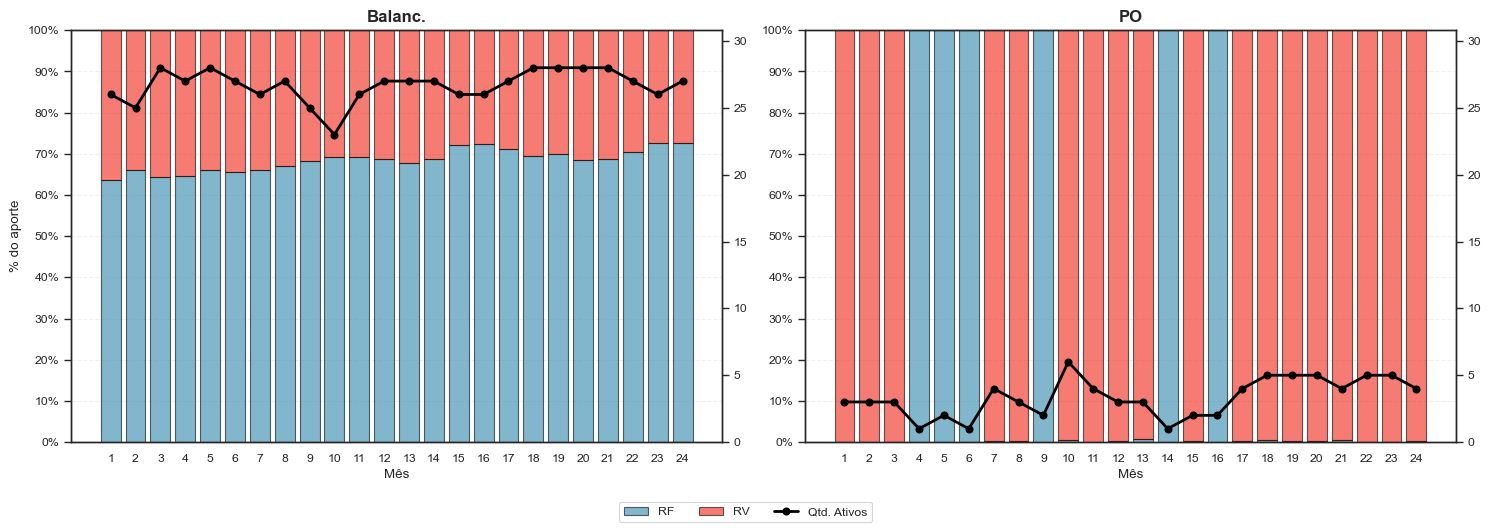

In [118]:
ordem_sub = (df_agg_dft["Classe"]\
             .dropna().unique().tolist())          # ordem fixa

# paleta    = sns.color_palette("Set2", len(ordem_sub))
# cores     = dict(zip(ordem_sub, paleta))           # {subclass: cor}

cores = {"RF": "#2E86AB","RV": "#F02314"}

def _tbl_pct(estr, col, ordem):
    tbl = (df_agg_dft.loc[df_agg_dft["Estrategia"] == estr]
           .pivot_table(index="Mes",
                         columns=col,
                         values="vlr_aport",
                         aggfunc="sum",
                         fill_value=0)
           .reindex(columns=ordem))            # mantém ordem
    pct = tbl.div(tbl.sum(axis=1), axis=0) * 100   # 100 %
    return pct

pct_def = _tbl_pct("Deficit", "Classe", ordem_sub)
pct_po  = _tbl_pct("PO", "Classe", ordem_sub)

fig, axes = plt.subplots(1, 2, figsize=(15,5))

for i, (ax, pct, titulo, estrategia) in enumerate([
        (axes[0], pct_def, "Balanc.", "Deficit"),
        (axes[1], pct_po,  "PO", "PO")]):
    
    # Criar eixo Y secundário
    ax2 = ax.twinx()
    
    # Plotar barras empilhadas no eixo principal
    bottom = np.zeros(len(pct))
    for sub in ordem_sub:
        ax.bar(pct.index, pct[sub],
               bottom=bottom,
               color=cores[sub],
               edgecolor='black',
            #    linewidth=.3,
               alpha=.6,
               width=0.8,
               label=sub)
        bottom += pct[sub].to_numpy()
    
    # Obter dados de quantidade de ativos para a estratégia específica
    qt_ativos_data = df_agg_qt_atv[df_agg_qt_atv["Estrategia"] == estrategia]
    
    # Plotar linha de quantidade de ativos no eixo secundário
    if not qt_ativos_data.empty:
        ax2.plot(qt_ativos_data["Mes"], 
                qt_ativos_data["ativos_dist_aport"], 
                color='black', 
                marker='o', 
                linewidth=2, 
                # markersize=6,
                label='Qtd. Ativos')
    
    # Configurações do eixo principal (barras)
    ax.set_title(titulo, fontsize=12, weight="bold")
    ax.set_xlabel("Mês")
    ax.set_ylabel("% do aporte" if i == 0 else "")
    ax.set_xticks(pct.index)
    ax.set_ylim(0, 100)
    ax.set_yticks(np.arange(0, 101, 10))
    ax.set_yticklabels([f'{i}%' for i in range(0, 101, 10)])
    ax.grid(ls="--", alpha=.3, axis="y")
    
    # Configurações do eixo secundário (linha)
    # ax2.set_ylabel("Qtd. Ativos" if i == 1 else "", color='black')
    # ax2.tick_params(axis='y', labelcolor='black')

    ax2.set_ylim(0, df_agg_qt_atv['ativos_dist_aport'].max()*1.1)
    
    # Ajustar limites do eixo secundário
    # if not qt_ativos_data.empty:
    #     max_ativos = qt_ativos_data["ativos_dist_aport"].max()
    #     ax2.set_ylim(0, max_ativos * 1.1)  # 10% de margem superior

# Criar legenda combinada
handles1, labels1 = axes[0].get_legend_handles_labels()
# handles2, labels2 = axes[1].twinx().get_legend_handles_labels()

# Adicionar handle da linha (usando o último eixo secundário criado)
if not df_agg_qt_atv.empty:
    line_handle = plt.Line2D([0], [0], color='black', marker='o', linewidth=2, label='Qtd. Ativos')
    handles1.append(line_handle)
    labels1.append('Qtd. Ativos')

fig.legend(handles1, labels1, ncol=3, bbox_to_anchor=(0.5,0), loc="upper center")

plt.tight_layout()
plt.show()

- A estratégia por Rebalanceamento mantém os aportes com as mesmas proporções ao longo dos meses, sendo maior em Renda Fixa. Além disso, a quantidade de ativos aportados é bastante pulverizada, buscando priorizar aportes para praticamente todos os ativos do portfolio;

- Em contrapartida, a estratégia por Pesquisa Operacional "direciona" os aportes de forma mais concentrada para as classes, podendo ser em Renda Fixa ou Renda Variável. A quantidade de ativos aportados também é reduzida.

#### Distribuição por Subclasses

In [119]:
ordem_subcl = df_agg_dft["Subclasses"].dropna().unique().tolist()

pct_def_subcl = _tbl_pct("Deficit", "Subclasses", ordem_subcl).fillna(0)
pct_po_subcl  = _tbl_pct("PO", "Subclasses", ordem_subcl).fillna(0)

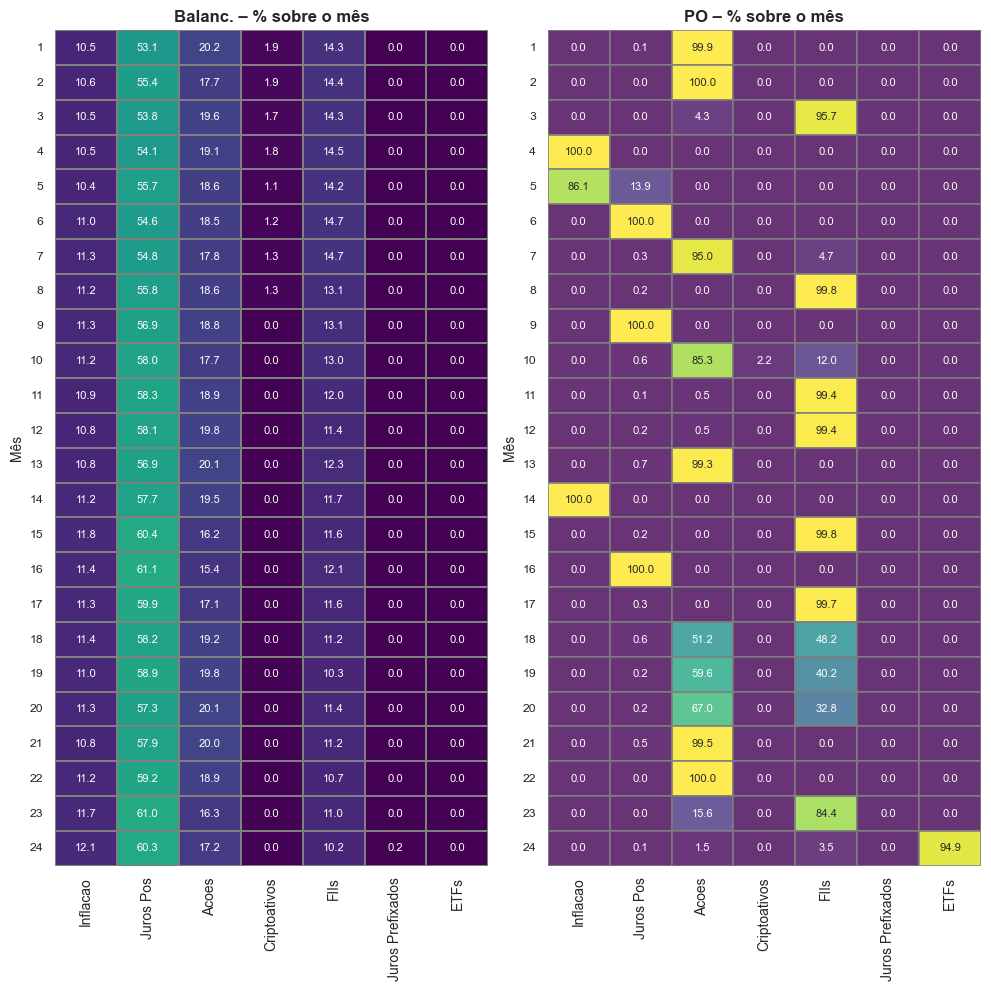

In [120]:
fig, axes = plt.subplots(ncols=2, figsize=(10, 10))

sns.heatmap(
    pct_def_subcl,
    ax      = axes[0],
    cmap    = 'viridis',
    annot   = True,
    fmt     = '.1f',
    vmin    = 0,
    vmax    = 100,
    linewidths=0.003,         # ← bordas
    linecolor="gray",
    annot_kws={"size": 8},
    cbar    = False
)

axes[0].set_title("Balanc. – % sobre o mês", fontsize=12, fontweight='bold')
axes[0].set_xlabel("")
axes[0].set_ylabel("Mês", fontsize=10)
axes[0].tick_params(axis="x", rotation=90, labelsize=10)
axes[0].tick_params(axis="y", rotation=0)

sns.heatmap(
    pct_po_subcl,
    ax      = axes[1],
    cmap    = 'viridis',
    alpha=.8,
    annot   = True,
    fmt     = '.1f',
    vmin    = 0,
    vmax    = 100,
    linewidths=0.003,         # ← bordas
    linecolor="gray",
    annot_kws={"size": 8},
    cbar=False
    # cbar_kws= {"label": "% da Subclasse no mês"}
)
axes[1].set_title("PO – % sobre o mês", fontsize=12, fontweight='bold')
axes[1].set_xlabel("")
axes[1].set_ylabel("Mês", fontsize=10)
axes[1].tick_params(axis="x", rotation=90, labelsize=10)
axes[1].tick_params(axis="y", rotation=0)

plt.tight_layout()
plt.show()

- Balanceamento: os aportes mantêm uma proporção quase fixa ao longo do tempo, com ~50-60 % sempre em Juros Pós; as demais subclasses recebem participações pequenas e constantes.

- Já para Pesquisa Operacional, cada mês o aporte é focado na subclasse que está mais distante da meta, direcionando muitas vezes para um 'único alvo' até reduzir o déficit, permitindo também uma correção mais rápida do portfolio

#### Eficiência dos Aportes na Carteira
- Como métrica de eficiencia, será contabilizada a redução do déficit por R$ investido
  - Δ = déficit mes anterior - deficit atual
  - Caso o Δ déficit for negativo, significa que o déficit da carteira aumentou, ocasionando eficiência negativa.

In [121]:
# 1. eficiência (Δ déficit por R$ investido no mês)
df_eff = df_out.copy()
df_eff["delta_deficit_def"] = (df_out["deficit_def"].shift(1) - df_out["deficit_def"]).fillna(0)
df_eff["delta_deficit_po"]  = (df_out["deficit_po"].shift(1)  - df_out["deficit_po"]).fillna(0)

df_eff["efic_def"] = (df_eff["delta_deficit_def"] / sim.aporte_mensal).fillna(0)
df_eff["efic_po"]  = (df_eff["delta_deficit_po"]  / sim.aporte_mensal).fillna(0)

pos_pct_def = (df_eff["delta_deficit_def"] > 0).mean() * 100     # em %
pos_pct_po  = (df_eff["delta_deficit_po"]  > 0).mean() * 100

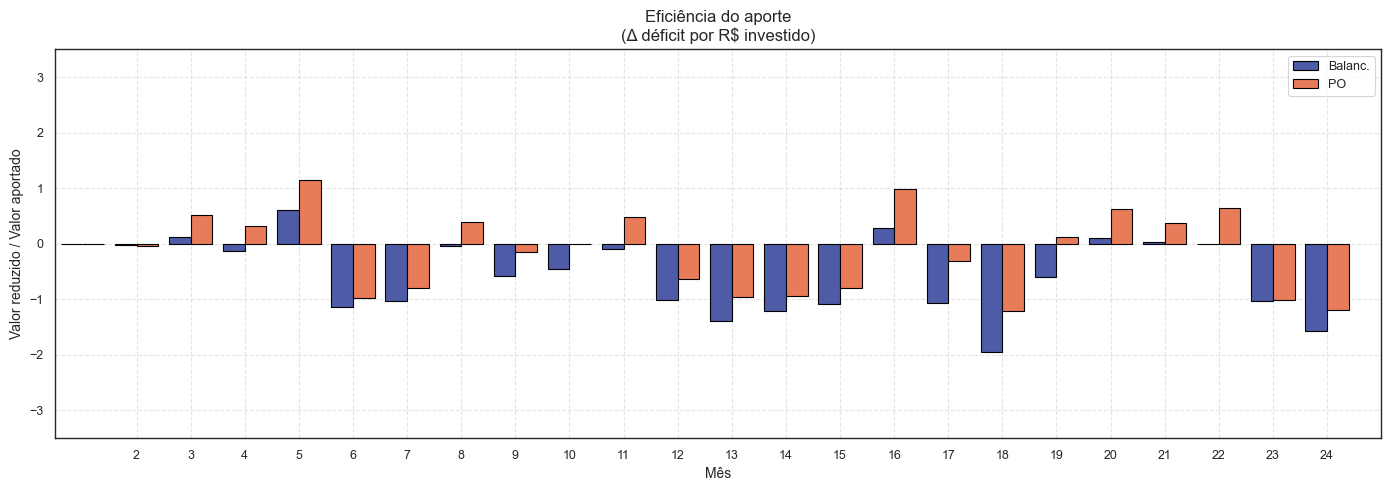

Método Balanc.:  25.0 % dos meses a eficiencia foi positiva
Método PO:       41.7 % dos meses a eficiencia foi positiva


In [122]:
df_long = (
    df_eff.loc[:, ["mes", "efic_def", "efic_po"]]
          .rename(columns={"efic_def": "Balanc.", "efic_po": "PO"})
          .melt(id_vars="mes", var_name="Estratégia", value_name="Eficiência")
)

palette = {"Balanc.": "#3F51B5", "PO": "#FF7043"}

plt.figure(figsize=(14, 5))

# --- barras Eficiência -----------------------------------------
sns.barplot(data=df_long, x="mes", y="Eficiência",
            hue="Estratégia", palette=palette, edgecolor='black')
plt.title("Eficiência do aporte\n(Δ déficit por R$ investido)", fontsize=12)
plt.xlabel("Mês", fontsize=10)
plt.ylabel(f"Valor reduzido / Valor aportado", fontsize=10)
plt.ylim([-3.5,3.5])
plt.xticks(df_eff["mes"])
plt.tick_params(axis='both', labelsize=9)
plt.grid(ls="--", alpha=.5)
plt.legend(frameon=True, fontsize=9)

plt.tight_layout()
plt.show()

print(f"Método Balanc.:  {pos_pct_def:4.1f} % dos meses a eficiencia foi positiva")
print(f"Método PO:       {pos_pct_po:4.1f} % dos meses a eficiencia foi positiva")

In [123]:
## Evolução da carteira e rentabilidade ?